<a href="https://colab.research.google.com/github/pinnouse/zeroshot-unsupervised-mt/blob/main/languages/train_jp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install apache_beam mwparserfromhell
!pip install transformers
!pip install datasets
# !pip install ftfy regex tqdm
# !pip install git+https://github.com/openai/CLIP.git

# multilingual CLIP pretrained
# https://github.com/FreddeFrallan/Multilingual-CLIP
# !pip install multilingual-clip
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 88.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.5/140.5 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 21.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 91.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.5/515.5 kB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 104.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for crcmod: filename=crcmod-1.7-cp39-cp39-linux_x86_64.whl size=36912 sha256=1e4dd11634d188e90271a5cde2e7d4164aa57a14

In [2]:
import os
import sys

repo = 'zeroshot-unsupervised-mt'
if os.path.isdir('zeroshot-unsupervised-mt'):
  !rm -rf {repo}

!git clone https://github.com/pinnouse/zeroshot-unsupervised-mt.git

if not repo in sys.path:
  sys.path.insert(1, repo)
print(sys.path)

Cloning into 'zeroshot-unsupervised-mt'...
remote: Enumerating objects: 291, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 291 (delta 104), reused 127 (delta 80), pack-reused 129
Receiving objects: 100% (291/291), 380.49 KiB | 15.22 MiB/s, done.
Resolving deltas: 100% (179/179), done.
['/content', 'zeroshot-unsupervised-mt', '/env/python', '/usr/lib/python39.zip', '/usr/lib/python3.9', '/usr/lib/python3.9/lib-dynload', '', '/usr/local/lib/python3.9/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.9/dist-packages/IPython/extensions', '/root/.ipython']


In [3]:
from datasets import load_dataset
from data_loader import data_loader
jp_train, jp_valid, jp_test = data_loader('jp')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/AhmedSSabir___text/AhmedSSabir--Japanese-wiki-dump-sentence-dataset-063b8dbed854cd7c/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
import pickle
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
with open('/content/gdrive/My Drive/CSC413/final/jp.pickle', 'wb') as f:
  pickle.dump({
      'train': jp_train,
      'validation': jp_valid,
      'test': jp_test,
  }, f, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
with open('/content/gdrive/My Drive/CSC413/final/en_reparsed.pickle', 'rb') as f:
  ds_en = pickle.load(f)
print(ds_en.keys())

dict_keys(['train', 'validation', 'test'])


In [6]:
from datetime import datetime
import numpy as np
import torch
from torch import nn
from transformers.optimization import Adafactor
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer
from models import Transformer, Decoder, Discriminator, Translator
from training import train

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
sentence_transformer = SentenceTransformer('sentence-transformers/clip-ViT-B-32-multilingual-v1')
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
transformer = Transformer(tokenizer.vocab_size, nlayers=3, d_hid=1024, dropout=0.1)
decoder = Decoder(tokenizer.vocab_size, nlayers=3)
translator = Translator(hidden=512)
discriminator = Discriminator()

transformer.to(device)
decoder.to(device)
sentence_transformer.to(device)
translator.to(device)
discriminator.to(device)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=512, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [8]:
decoder_checkpoint = torch.load('/content/gdrive/My Drive/CSC413/final/ckpt-Decoder-epoch-49.pt')

Epoch 1:


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


	train loss (decoder)   : 0.0
	train loss (generator) : 7.840951663476449
	train loss (discrim)   : 0.8532556703797093
	train loss (translator): 0.5924668411413828
	took: 25.717119 seconds
Probability Discriminator classifies English Embs:  tensor(0.5425, device='cuda:0')
Probability Discriminator classifies Other Embs as English Embs:  tensor(0.6603, device='cuda:0') 

Epoch 2:
	train loss (decoder)   : 0.0
	train loss (generator) : 6.099950525495741
	train loss (discrim)   : 0.8501708982167421
	train loss (translator): 0.7649159696367052
	took: 22.686165 seconds
Probability Discriminator classifies English Embs:  tensor(0.4053, device='cuda:0')
Probability Discriminator classifies Other Embs as English Embs:  tensor(0.5500, device='cuda:0') 

Epoch 3:
	train loss (decoder)   : 0.0
	train loss (generator) : 5.055039432313707
	train loss (discrim)   : 0.7672637866603004
	train loss (translator): 0.9360209968354967
	took: 22.633677 seconds
Probability Discriminator classifies English Em

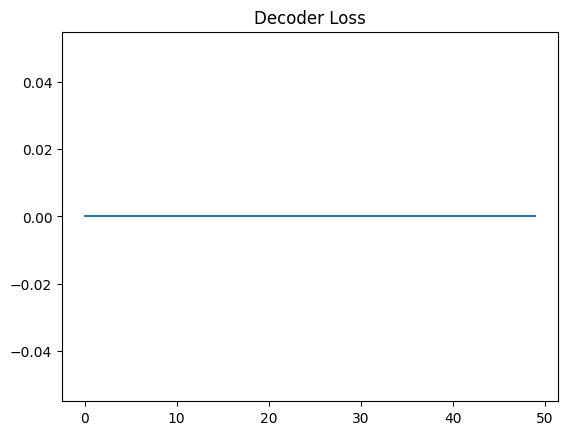

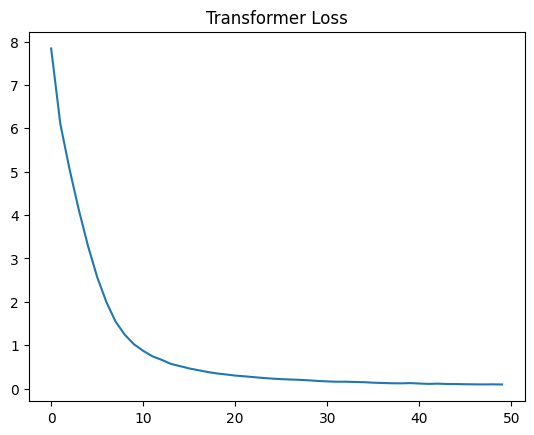

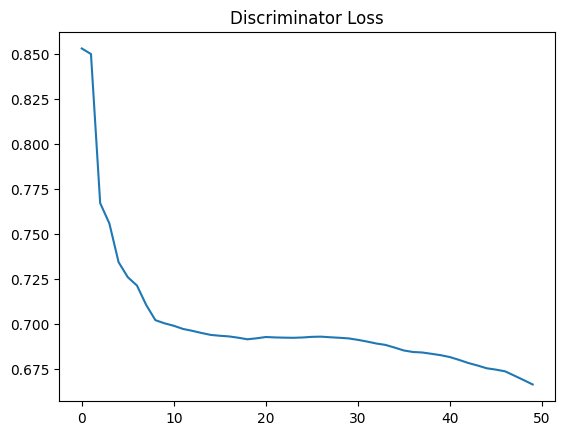

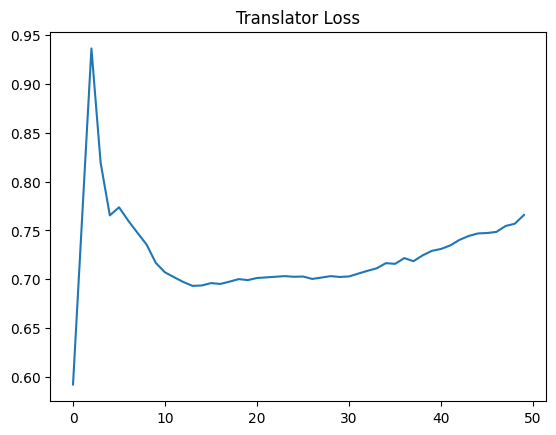

In [9]:
ckpt_path = '/content/gdrive/My Drive/CSC413/final/'
train(decoder, transformer, discriminator, translator, tokenizer, real_train=ds_en['train'], 
       other_train=jp_train, real_valid=ds_en['validation'], other_valid=jp_train, device=device, 
       ckpt_path=ckpt_path, batch_size=128, ckpt_interval=10, epochs=50, decoder_checkpoint=decoder_checkpoint) 
